In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#### Data Cleaning

In [2]:
#Detect and crop face and eyes

In [3]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')


In [4]:
def get_cropped_image_with_2eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return  roi_color

In [5]:
path_to_data = "./Dataset/"
path_to_cr_data = "./Dataset/cropped/"

In [6]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)


In [7]:
img_dirs

['./Dataset/lionel_messi',
 './Dataset/maria_sharapova',
 './Dataset/roger_federer',
 './Dataset/serena_williams',
 './Dataset/virat_kohli']

In [8]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [9]:
cropped_image_dirs = []
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_with_2eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            count += 1

Generating cropped images in folder:  ./Dataset/cropped/lionel_messi
Generating cropped images in folder:  ./Dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./Dataset/cropped/roger_federer
Generating cropped images in folder:  ./Dataset/cropped/serena_williams
Generating cropped images in folder:  ./Dataset/cropped/virat_kohli


In [10]:
cropped_image_dirs

['./Dataset/cropped/lionel_messi',
 './Dataset/cropped/maria_sharapova',
 './Dataset/cropped/roger_federer',
 './Dataset/cropped/serena_williams',
 './Dataset/cropped/virat_kohli']

In [11]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./Dataset/cropped/lionel_messi\\lionel_messi1.png',
  './Dataset/cropped/lionel_messi\\lionel_messi10.png',
  './Dataset/cropped/lionel_messi\\lionel_messi11.png',
  './Dataset/cropped/lionel_messi\\lionel_messi13.png',
  './Dataset/cropped/lionel_messi\\lionel_messi14.png',
  './Dataset/cropped/lionel_messi\\lionel_messi15.png',
  './Dataset/cropped/lionel_messi\\lionel_messi16.png',
  './Dataset/cropped/lionel_messi\\lionel_messi17.png',
  './Dataset/cropped/lionel_messi\\lionel_messi18.png',
  './Dataset/cropped/lionel_messi\\lionel_messi19.png',
  './Dataset/cropped/lionel_messi\\lionel_messi2.png',
  './Dataset/cropped/lionel_messi\\lionel_messi20.png',
  './Dataset/cropped/lionel_messi\\lionel_messi22.png',
  './Dataset/cropped/lionel_messi\\lionel_messi23.png',
  './Dataset/cropped/lionel_messi\\lionel_messi24.png',
  './Dataset/cropped/lionel_messi\\lionel_messi25.png',
  './Dataset/cropped/lionel_messi\\lionel_messi26.png',
  './Dataset/cropped/lionel_messi\

#### Feature Engineering

In [12]:
import pywt   

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [13]:
class_celeb = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_celeb[celebrity_name] = count
    count += 1
class_celeb

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [14]:
X = []
y = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_img in training_files:
        img = cv2.imread(training_img)
        scaled_img = cv2.resize(img, (32,32))
        img_har = w2d(img, "db1", 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_celeb[celebrity_name])

In [15]:
len(X)

161

In [16]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(161, 4096)

##### Import necessary libraries

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#### Modeling

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
model = Pipeline(
    [("scaler", StandardScaler()), ("svm", SVC(kernel = "rbf", C = 10))]
)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9024390243902439

In [19]:
y_pred = model.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      0.92      0.96        12
           2       0.86      1.00      0.92         6
           3       0.80      0.67      0.73         6
           4       0.83      1.00      0.91        10

    accuracy                           0.90        41
   macro avg       0.90      0.89      0.89        41
weighted avg       0.91      0.90      0.90        41



In [21]:
len(X_train)

120

In [22]:
len(X_test)

41

#### Grid Search

In [23]:
model_params = {
    "svm" : {
        "model": SVC(gamma = "auto", probability = True),
        "params": {
            "svc__C": [1, 10, 100, 1000],
            "svc__kernel": ["linear", "rbf"]
        }
    },

    "random_forest": {
        "model": RandomForestClassifier(),
        "params":{
            "randomforestclassifier__n_estimators": [1, 5, 10]
        }
    },

    "logistic_regression": {
        "model": LogisticRegression(solver='liblinear',multi_class='auto'),
        "params": {
            "logisticregression__C": [1, 5, 10]
        }
        
    }
}

In [25]:
import pandas as pd

In [26]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp["model"])
    clf = GridSearchCV(pipe, mp["params"], cv = 5)
    clf.fit(X_train, y_train)
    scores.append({
        "model": algo,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_  
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns = ["model", "best_score", "best_params"])
df  

,model,best_score,best_params
0,svm,0.858333,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.675000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.891667,{'logisticregression__C': 10}


In [27]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [28]:
best_estimators["svm"].score(X_test, y_test)

0.9024390243902439

In [29]:
best_estimators["random_forest"].score(X_test, y_test)

0.6097560975609756

In [30]:
best_estimators["logistic_regression"].score(X_test, y_test)

0.8780487804878049

In [31]:
best_model = best_estimators["svm"]

##### Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm

array([[ 5,  1,  0,  1,  0],
       [ 0, 12,  0,  0,  0],
       [ 0,  0,  6,  0,  0],
       [ 0,  1,  1,  4,  0],
       [ 0,  0,  0,  0, 10]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

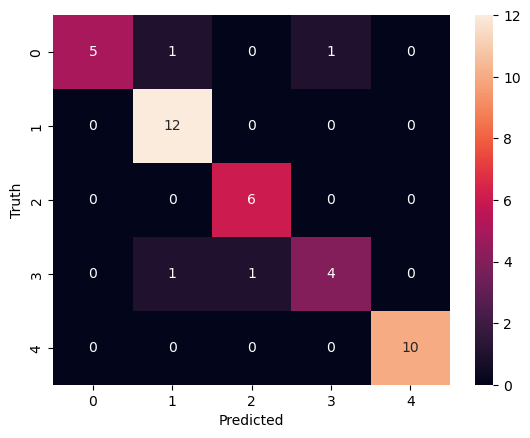

In [33]:
import seaborn as sn
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Save Model

In [34]:
import joblib

In [35]:
joblib.dump(best_model, "svm_model.pkl")

['svm_model.pkl']

#### Save Dictionary

In [36]:
import json

In [37]:
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_celeb))